![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in Deep Learning-Based Signal Analysis: The Gradient-weighted Class Activation Mapping (Grad-CAM)

In this Notebook, we will delve into the utilization of Grad-CAM to reveal the regions of a signal that a ResNet-50 model trained on signal data considers crucial during its prediction process.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you can execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/Juelich-2024/xai-for-cnn/Tutorial_Grad-CAM_for_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also receive an email that informs you about the access on your Google Drive.

In [43]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-for-cnn


## Imports, data and model loading

In [1]:
%matplotlib inline
import sys 
import shutil 
import warnings
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

sys.path.append('../data_and_models/ECG')
from ResNet1D import ResNet, ResNetBlock
from ECG import ECG

warnings.filterwarnings("ignore")


We fix the random seeds to ensure reproducible results as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)


Let's first download the dataset.

In [3]:
dataset_path = "../data_and_models/ECG/ECG_test_data/"

In [4]:
!mkdir ../data_and_models/ECG/data
!unzip ../data_and_models/ECG/ECG_test_data.zip -d ../data_and_models/ECG/ECG_test_data


Archive:  ../data_and_models/ECG/ECG_test_data.zip
  inflating: ../data_and_models/ECG/ECG_test_data/mitbih_test.csv  


We have trained a modified version of ResNet-50 model for ten epochs on the Electrocardiogram (ECG) Heartbeat Categorization Dataset. The original ResNet-50 architecture typically employs 2D convolutional layers (conv2d) as it is primarily designed for processing 2D data, such as images. However, when adapting ResNet-50 for 1D data, such as time series or audio data, the architecture is modified to use 1D convolutional layers (conv1d) instead. This modification is essential to make the network suitable for analyzing 1D data, as the conv1d layers are specifically designed to process data with only one spatial dimension.

The dataset comprises two groups of heartbeat signals, originating from two well-known heartbeat classification datasets - the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. We used the MIT-BIH Arrhythmia Dataset to train our model. This dataset consists of 87554 samples for train, 21892 samples for test, and five categories (['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4])

The dataset is organized in CSV files. Inside every CSV file, there's a matrix structure. Each row in the matrix signifies an individual ECG signal instance. The last column in each row determines the specific category the example belongs to. For more details about the dataset, please refer to [1].

The model on test data shows a high accuracy of 99.37% and a low average loss of 0.061. The F1 scores, which are the harmonic mean of precision and recall, are 99.19%, 81.33%, 95.93%, 81.31%, and 99.12% for the classes N, S, V, F, and Q, respectively. These scores suggest a balanced performance between precision and recall, with the second and fourth classes showing slightly lower F1 scores. 

If you want to know more about the training and the inference results, please check the files under the folder "data_and_models/ECG"

Let's set some paths. We provide the path of the model's weight and the location of the test data. 

In [7]:
model_weights_path = '../data_and_models/ECG/weights/resnet1d_final_weights_ecg.pth'
test_data_path = '../data_and_models/ECG/ECG_test_data/mitbih_test.csv'


Consequently, we have created an ECG class that loads the dataset.

In [8]:
ecg = ECG(test_data_path)

Now, let's load our trained model.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(ResNetBlock, [2, 2, 2, 2], num_classes=5)
model = model.to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device=device)))
model.eval()

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=F

## Generating a Grad-CAM

To generate a Grad-CAM in a CNN, we follow a series of steps:

#### Step 1: Train the model

First, we train our model. The CNN processes the input signal through its convolutional layers, resulting in a set of feature maps at the end of these layers. The architecture should look like this:

- Convolutional layers
- Fully connected layer (FC)

#### Step 2: Forward Pass

Once the model is trained, we can generate our Grad-CAM. We perform a forward pass with the input signal through the network. We obtain the feature maps from the last convolutional layer. We denote these feature maps as $ f_k(i, j) $, where $ k $ is the index of the feature map, and $ (i, j) $ are spatial coordinates.

#### Step 3: Obtain the Weights

Then, the output corresponding to the target class is selected and the loss is calculated, which is necessary for computing gradients.

We compute gradients of the target class score with respect to feature maps of the selected convolutional layer.

#### Step 4: Compute the Grad-CAM

Compute the Grad-CAM for a specific class $ c $ using the formula:

$
Grad-CAM_c(i, j) = ReLU (\sum_k a_k^c \cdot f_k(i, j))
$

where 

$
a^{c}_{k} = \frac{1}{Z} \sum_{i} \sum_{j} \frac{\partial y^{c}}{\partial f_{k}^{(i,j)}}
$

This formula calculates the Grad-CAM as a weighted sum of the feature maps, where the weights are the importance of a feature map for a target class.

#### Step 5: Post-processing

- Resize the Grad-CAM to match the size of the input signal.
- Apply a heatmap or color map for better visualization.
- Overlay the Grad-CAM on the original signal to identify the regions most relevant for the specific class.

The Grad-CAM highlights areas in the input signal that are significant for CNN's prediction of class $ c $, providing insights into what the network 'sees' as important for its decision-making.

In our scenario, the ResNet-50 architecture comprises a series of convolutional layers, succeeded by GAP, a fully connected layer, and a softmax layer. Given this setup, we can generate our Grad-CAM.

We create the `return_grad_cam` function that generates a Grad-CAM for a specific input and class label using our trained ResNet-50.
The function proceeds as follows:

1. The model processes the input `x`, returning two outputs: `conv_map`, the feature maps from the last convolutional layer, and `logits`, the class scores (before softmax activation).
2. We then create a copy of the feature maps, ensuring they do not impact the computational graph's gradients.
3. Then, we extract weights from the model's fully connected layer `fc`, specifically those associated with the `label`. These weights are crucial for determining the important parts of the feature maps for the specified class.
4. Next, the function reshapes `grad_cam_weights` to align with the dimensions of the feature maps. It then multiplies these reshaped weights with `feature_map`. Following this, the function computes the weighted sum across the feature maps. This operation yields a tensor, which is the Grad-CAM. The Grad-CAM effectively highlights regions important for predicting the specified class.
5. Finally, we return the generated Grad-CAM and logits. 

In [10]:
def calculate_localization_map(gcmodel, out,  conv_map, c):

    # Step 1 - Gradient output y wrt. to activation map
    # get the gradient of the output with respect to the parameters of the model
    out[:,c].backward(retain_graph=True)
    
    # pull the gradients out of the model
    gradients = gcmodel.get_gradient()
    
    # Step 2 - Global average pooling
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2])
    
    # Step 3 - Weighted combination of influence and feature maps
    # get the activations of the last convolutional layer
    activations = conv_map.detach()
    
    # weight the channels by corresponding gradients
    for i in range(activations.size(1)):
        activations[:, i, :] *= pooled_gradients[i]
    
    # average the channels of the activations
    localization_map = torch.sum(activations, dim=1).squeeze()
    
    # convert the map to be a numpy array
    localization_map = localization_map.numpy()
    
    # relu on top of the localization map
    localization_map = np.maximum(localization_map, 0)
    
    return localization_map

We code some utility functions—the normalize_scoremap function to normalize the Grad-CAM and the t2n function to transform a numpy array to a tensor.

We also have a function named plot_Grad_cam that takes the Grad_cam and the signal to plot them in a single figure. The code line uses Matplotlib's `imshow` to display a Grad-CAM with a red color map (`cmap='Reds'`) over a signal plot. The aspect ratio is set to 'auto' to fit the image to the axes, and `extent` aligns the Grad-CAM's dimensions with the signal's length and value range. The Grad-CAM is fully opaque (`alpha=1.0`), providing a clear overlay to highlight regions in the signal that are influential for the model's predictions. 

In [11]:
def convert_to_heatmap(localization_map, signal):
    # normalize the localization_map
    localization_map /= np.max(localization_map)
    
    # resize to image size
    localization_map = np.expand_dims(localization_map, axis=0)
    heatmap = cv2.resize(localization_map, (signal.shape[1], signal.shape[0]))
    
    # normalize to [0, 255] range and convert to unsigned int
    heatmap = np.uint8(255 * heatmap)
    return heatmap 

def plot_grad_cam(grad_cam, signal):
    fig, axs = plt.subplots(figsize=(25,5))
    
    pcm = axs.imshow(grad_cam, cmap='Reds',  aspect="auto", \
        extent=[0, len(signal[0]), math.floor(signal[0].min()), math.ceil(signal[0].max())], alpha=1.0)
    axs.plot(signal[0], 'k')
    fig.colorbar(pcm, ax=axs, shrink=0.6)

    # Draw a grid with a spacing of 1 millimeter
    axs.set_xticks(np.arange(0, 188, 1), minor=True)
    axs.set_yticks(np.arange(0, 1, 0.01), minor=True)
    axs.grid(which='major', color='black', linestyle='-', linewidth=0.5)
    axs.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

    plt.show()


Let's generate the 5 Grad-CAMs for each class in the test set. Once the Grad-CAM is generated, we resize it to the same size as the original signal and normalize the values. We then plot the result.

In [12]:
def get_prediction(idx):
    samples = ecg[idx]
    signal = samples[0]
    label = samples[1]

    logits, conv_map = model(signal.unsqueeze(0).to(device))

    localization_map = calculate_localization_map(model, logits, conv_map, label)
    heatmap = convert_to_heatmap(localization_map, signal)
    
    outputs = logits[0]
    _, predictions = torch.max(outputs, -1)
    if predictions.item() == label:
        plot_grad_cam(heatmap, signal)


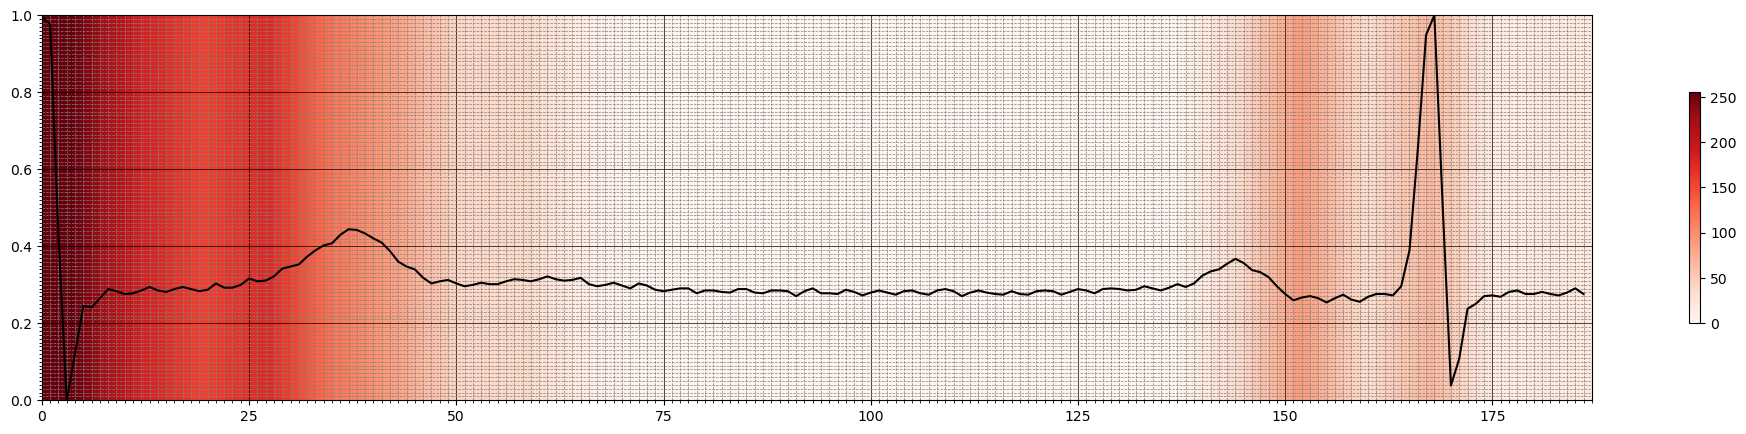

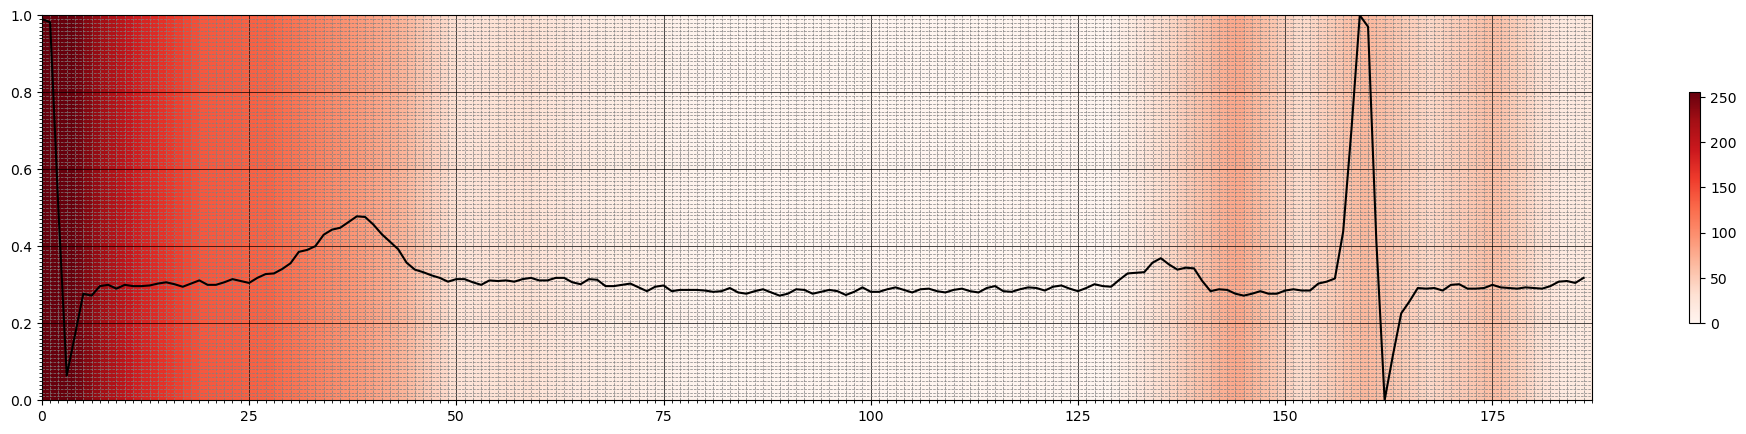

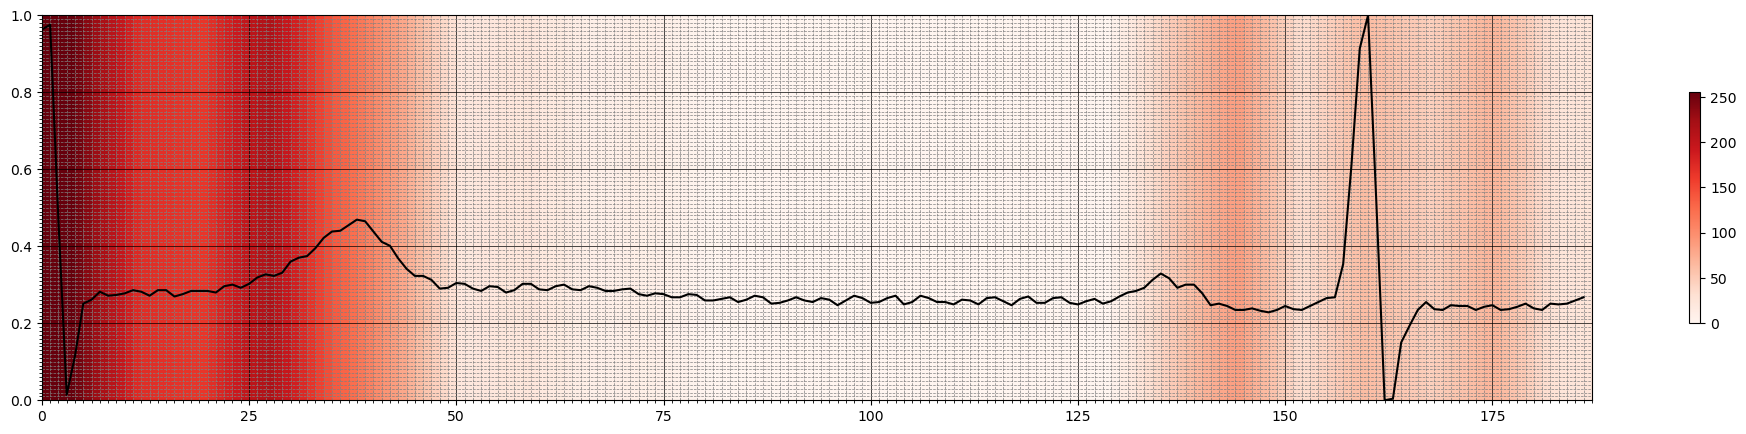

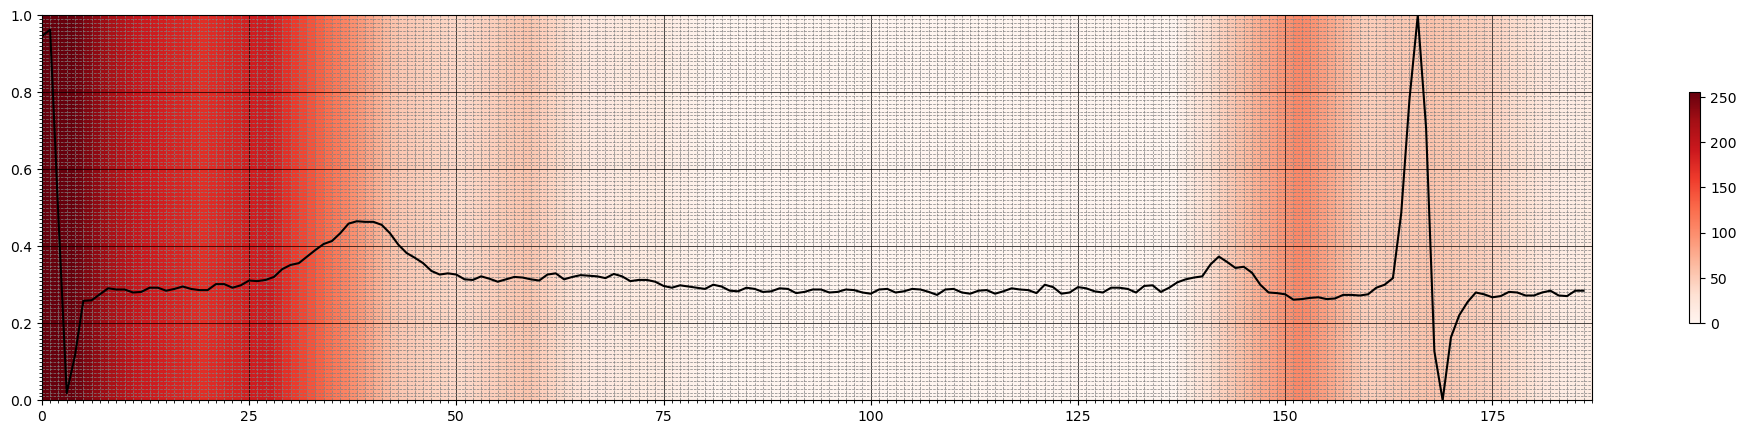

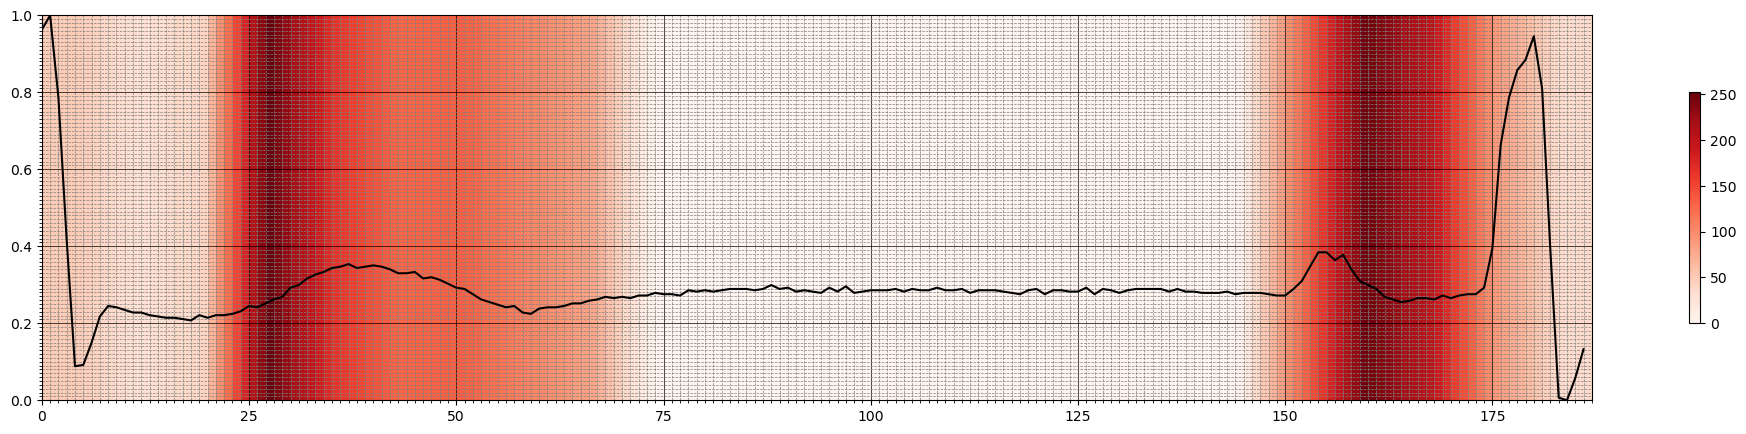

In [13]:
# Grad-CAMs that belongs to class N
normal_ecg_indexes = [936, 1452, 2824, 3878, 6041]
for i in normal_ecg_indexes:
  get_prediction(i)

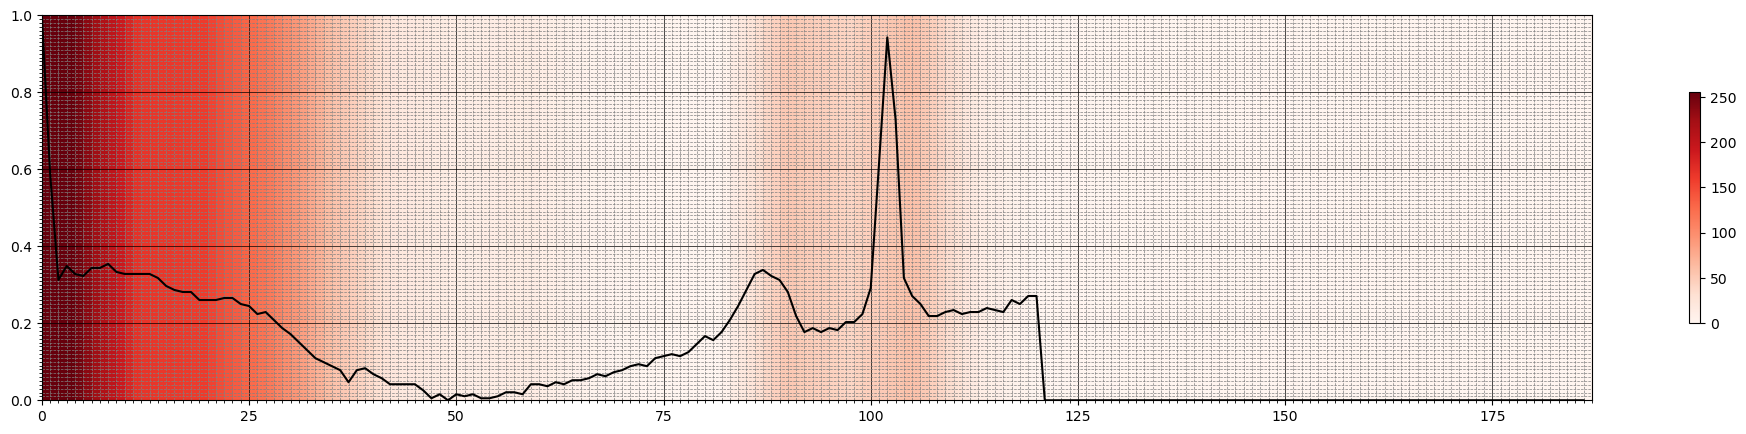

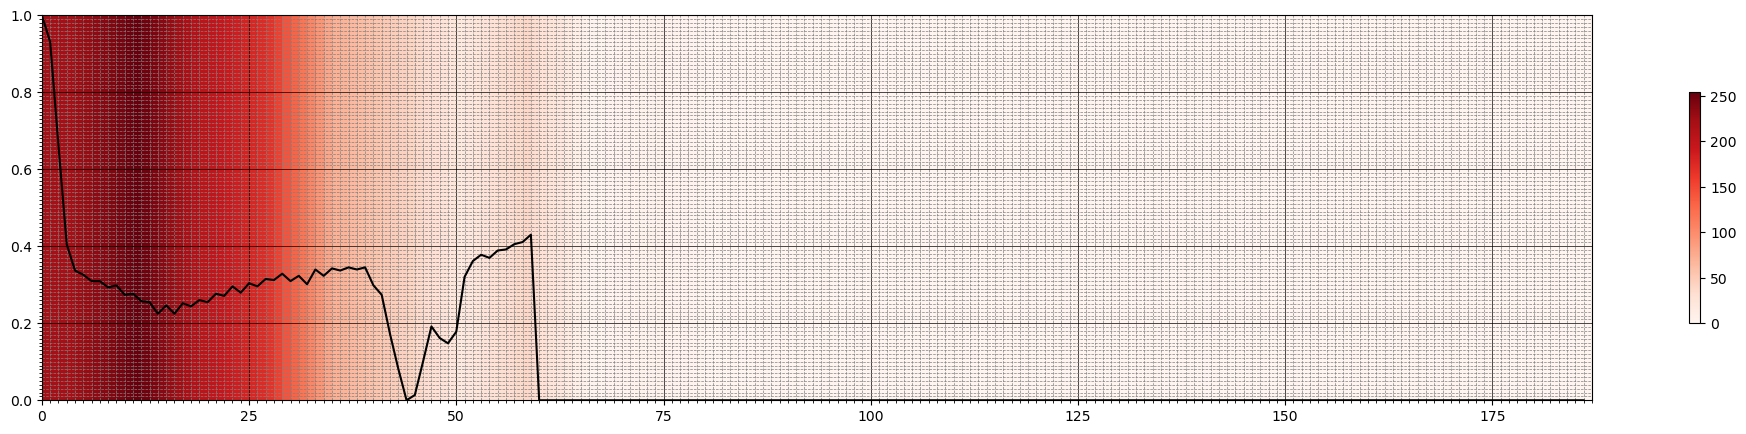

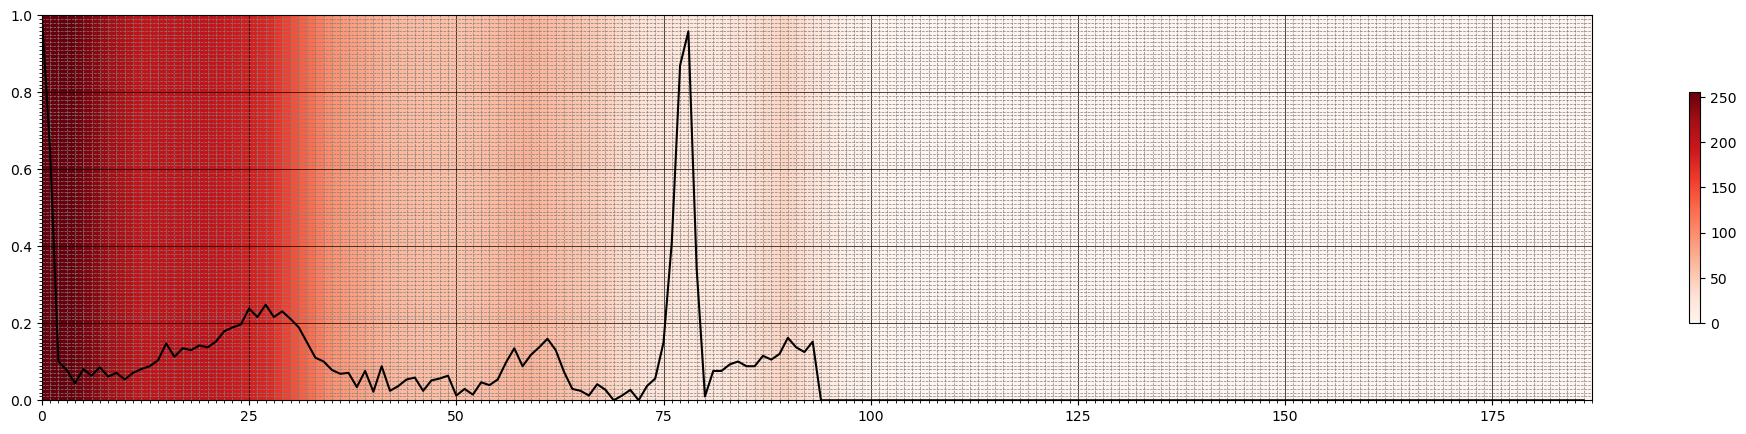

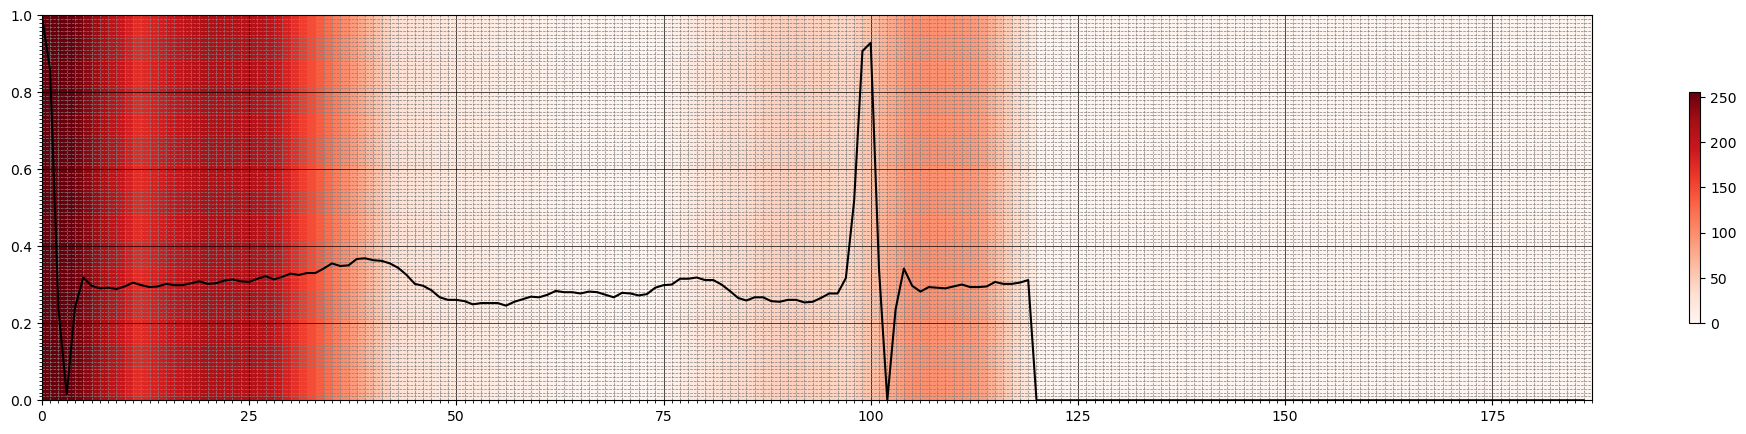

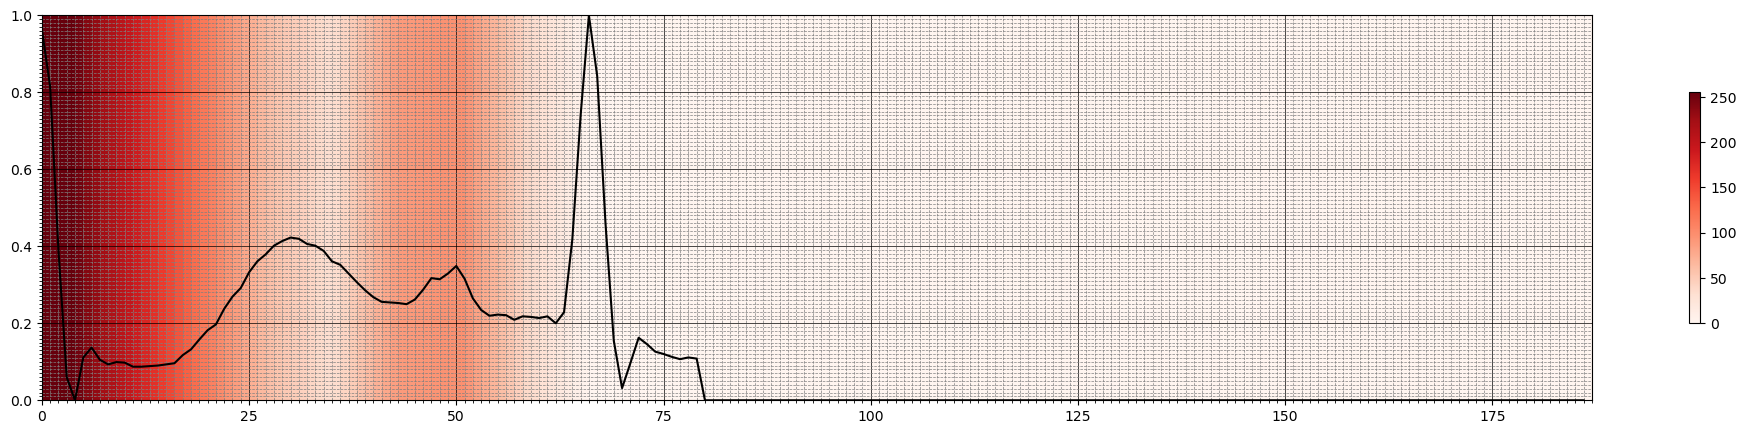

In [14]:
# Grad-CAMs that belongs to class S 
for i in range(18005,18010):
  get_prediction(i)


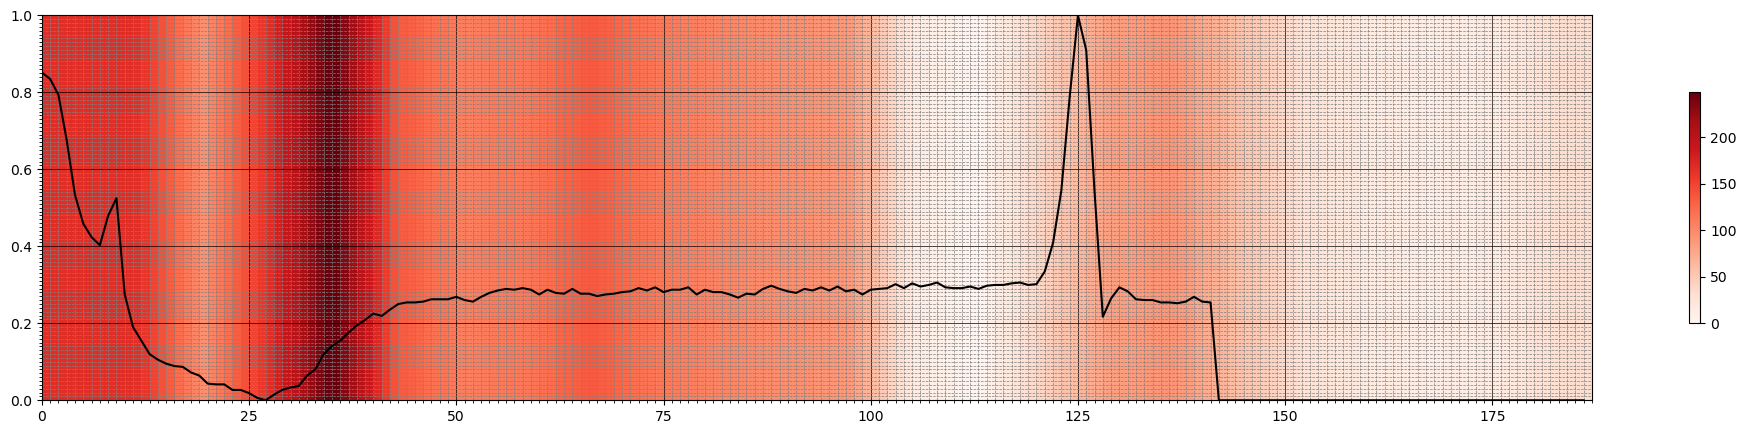

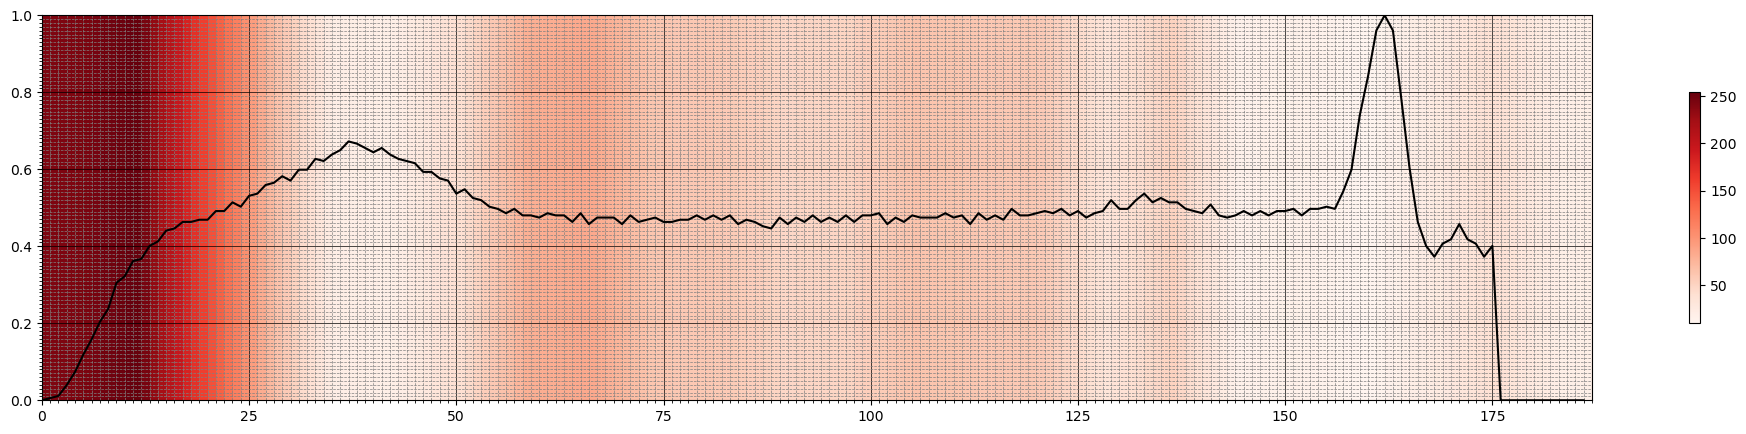

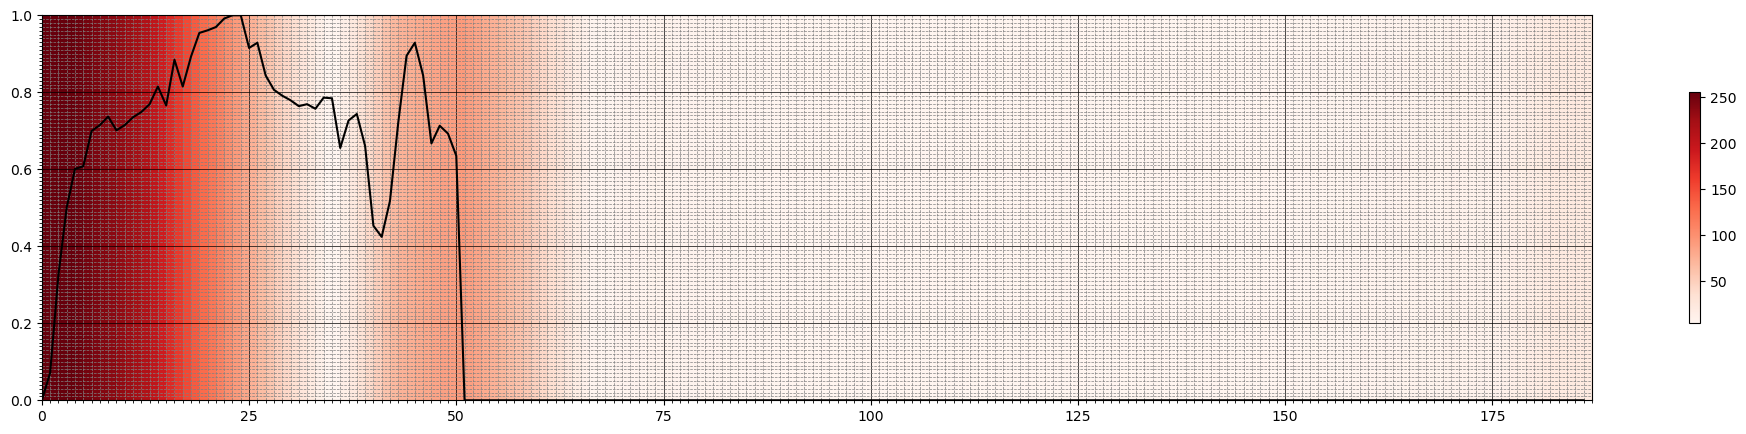

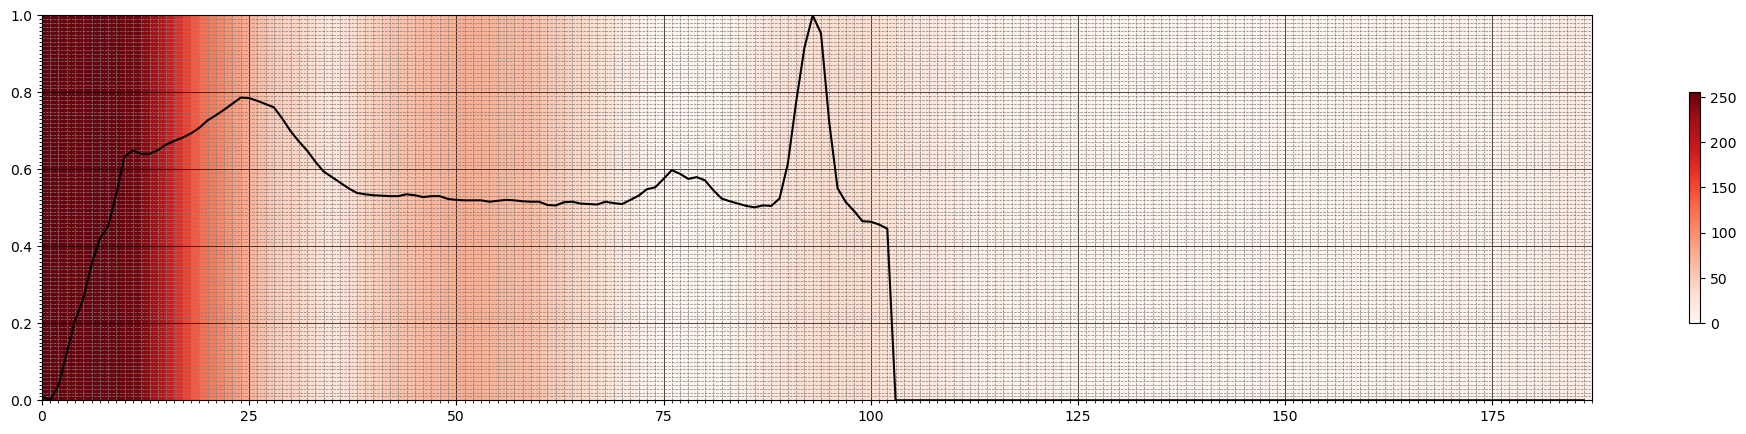

In [15]:
# Grad-CAMs that belongs to class V 
for i in range(18890,18895):
  get_prediction(i)


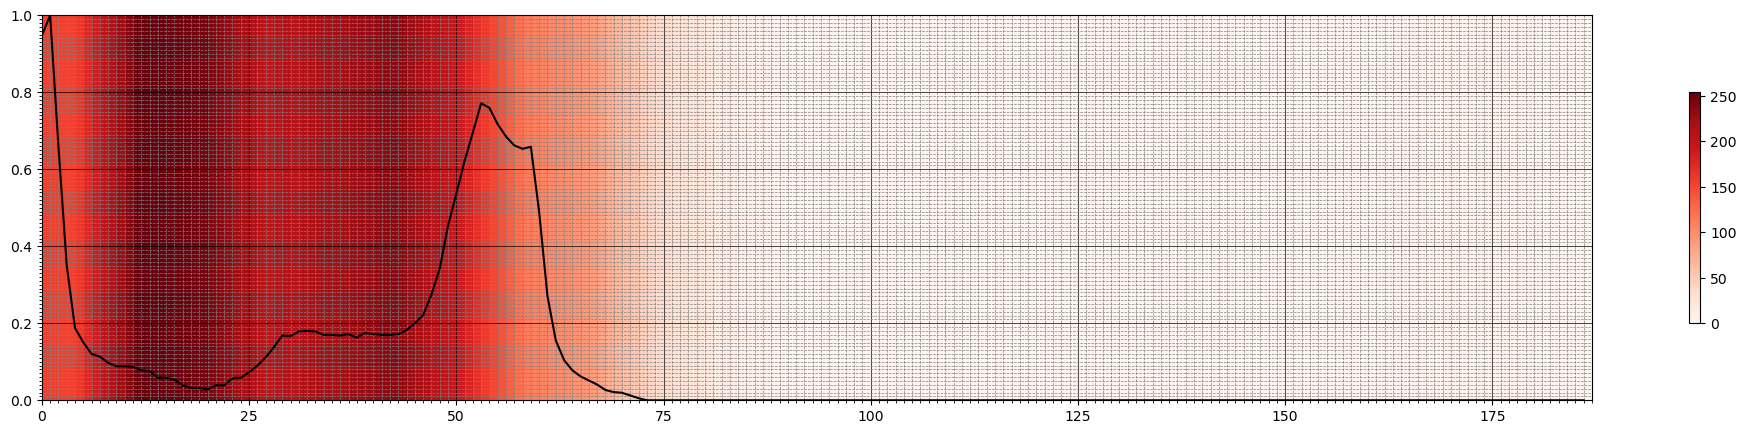

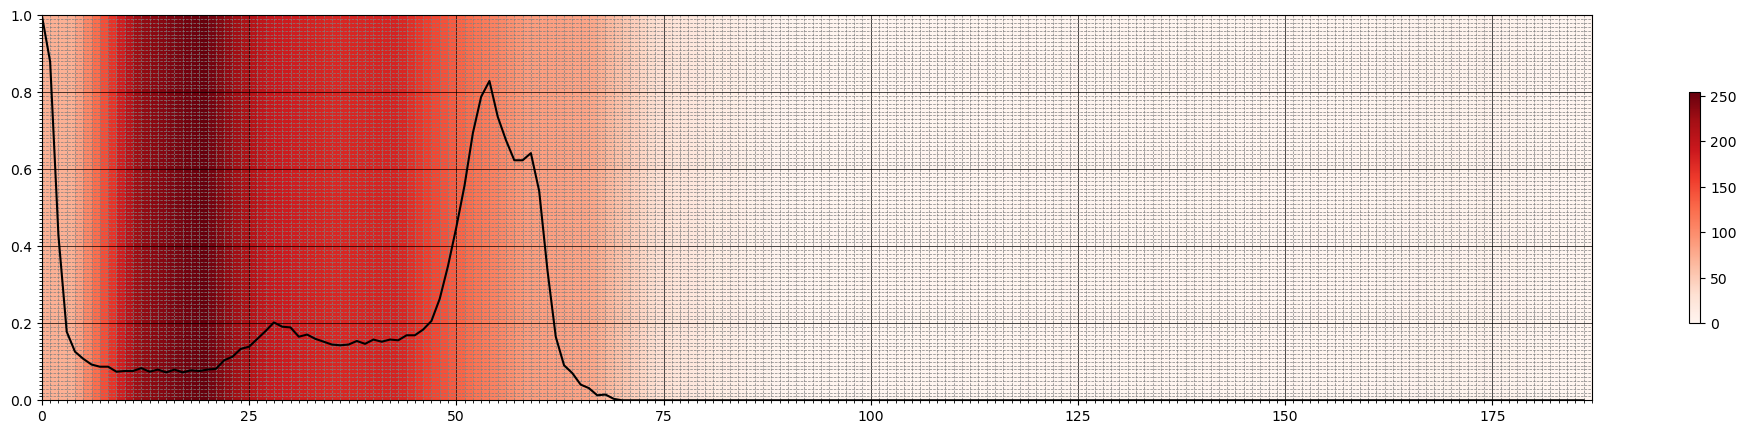

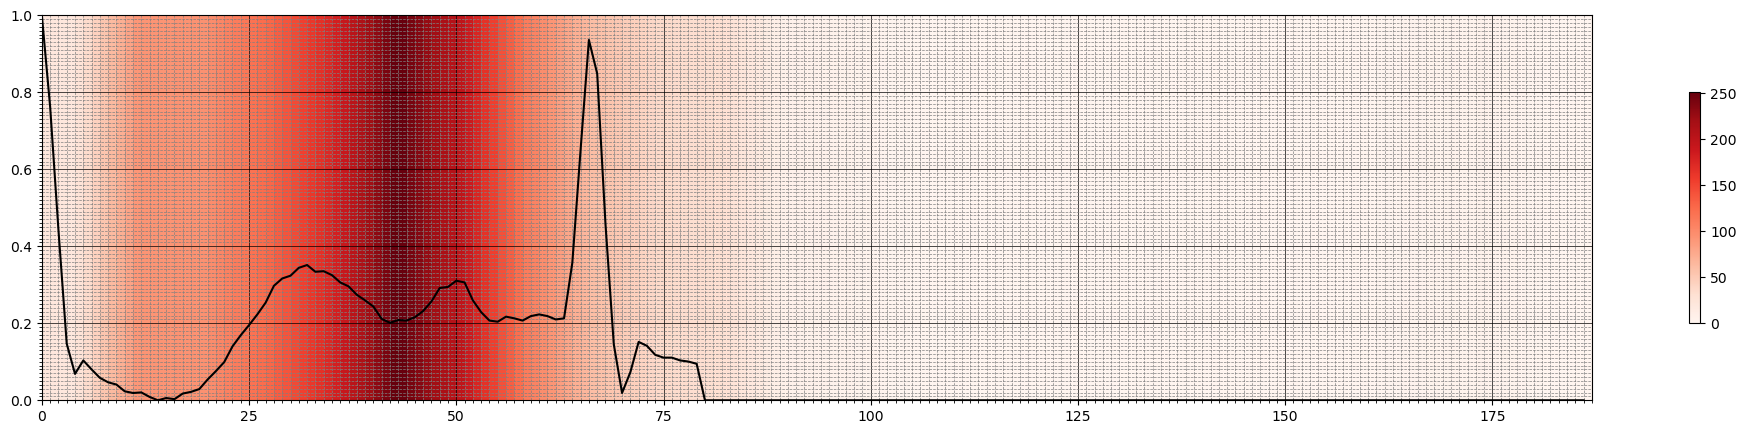

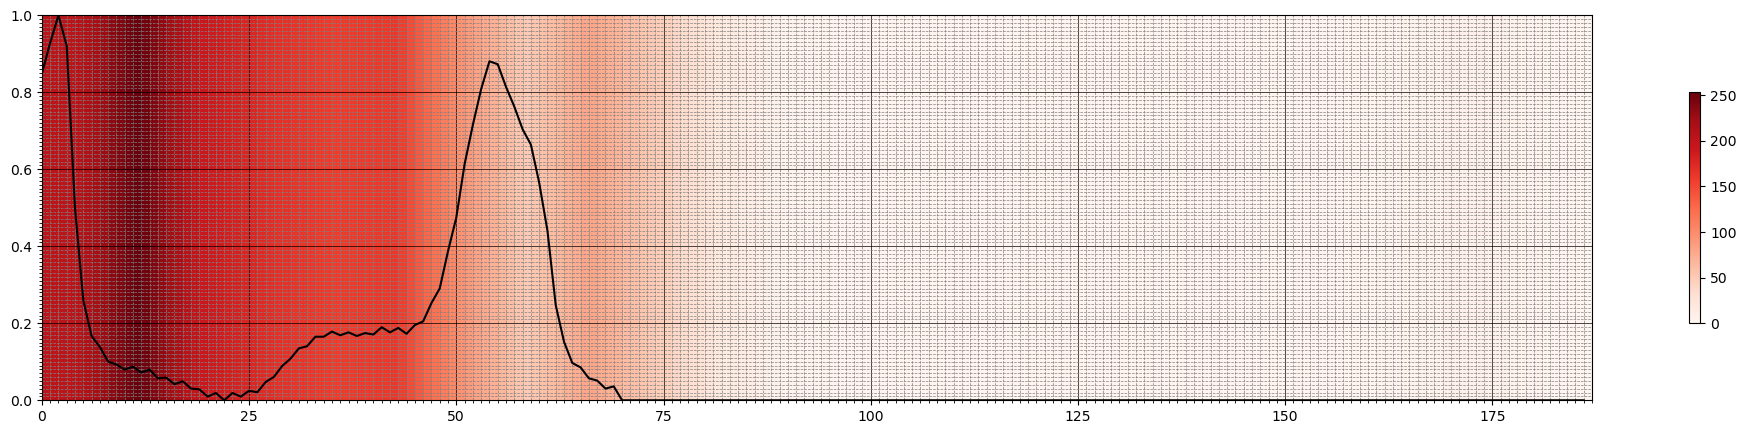

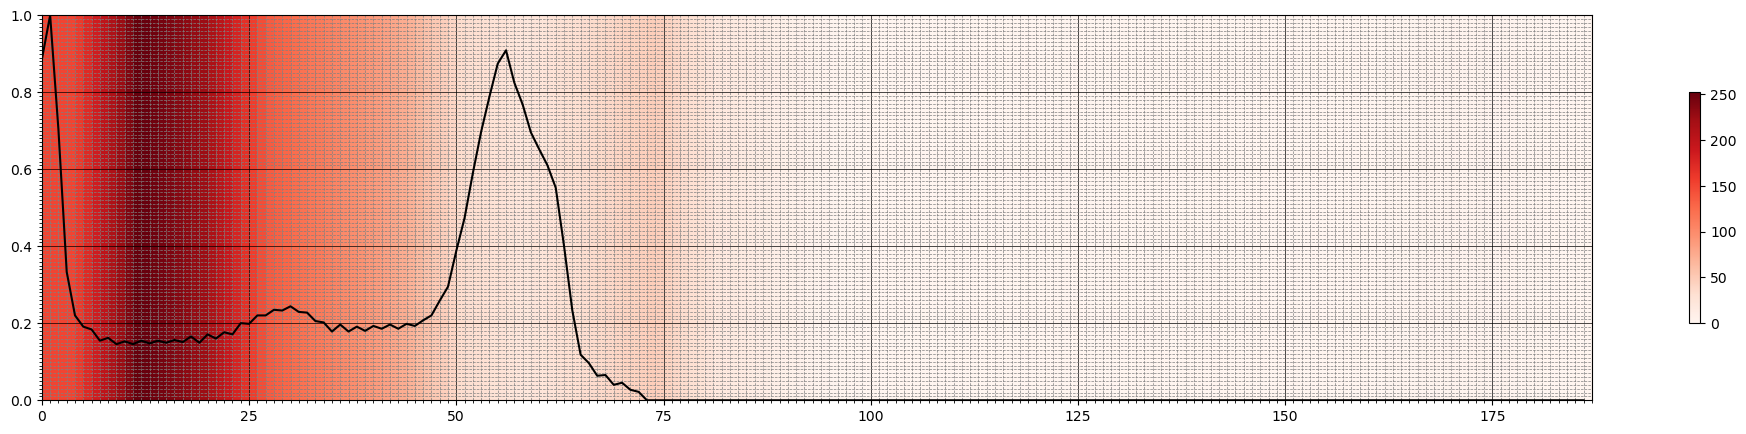

In [16]:
# Grad-CAMs that belongs to class F 
for i in range(20201,20207):
  get_prediction(i)


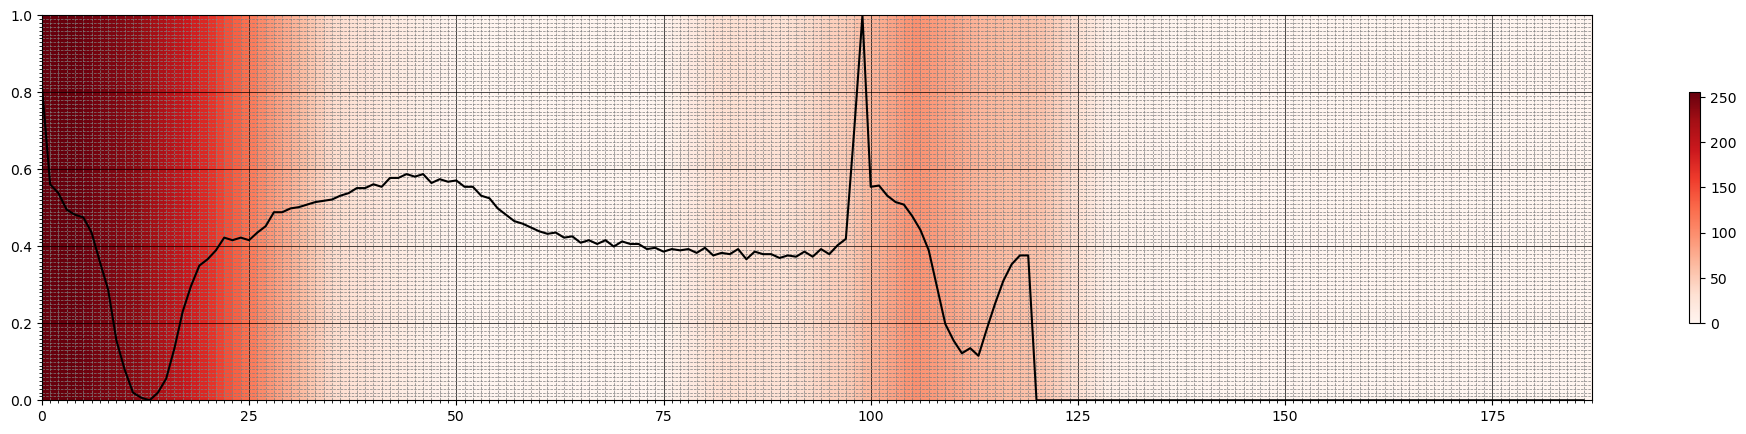

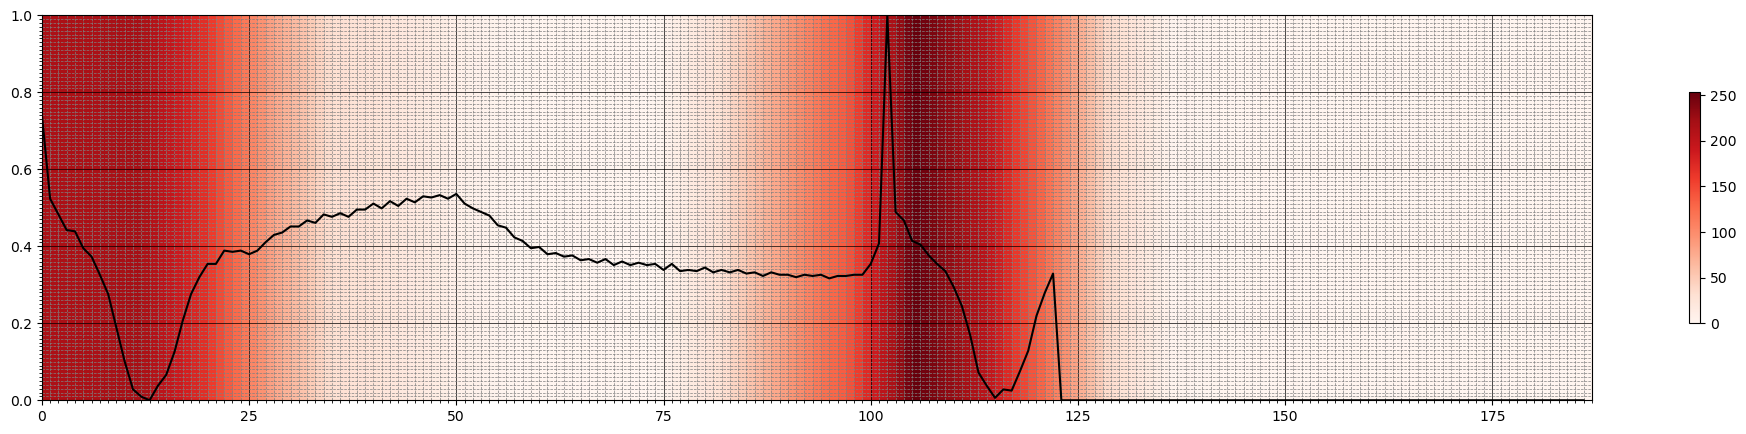

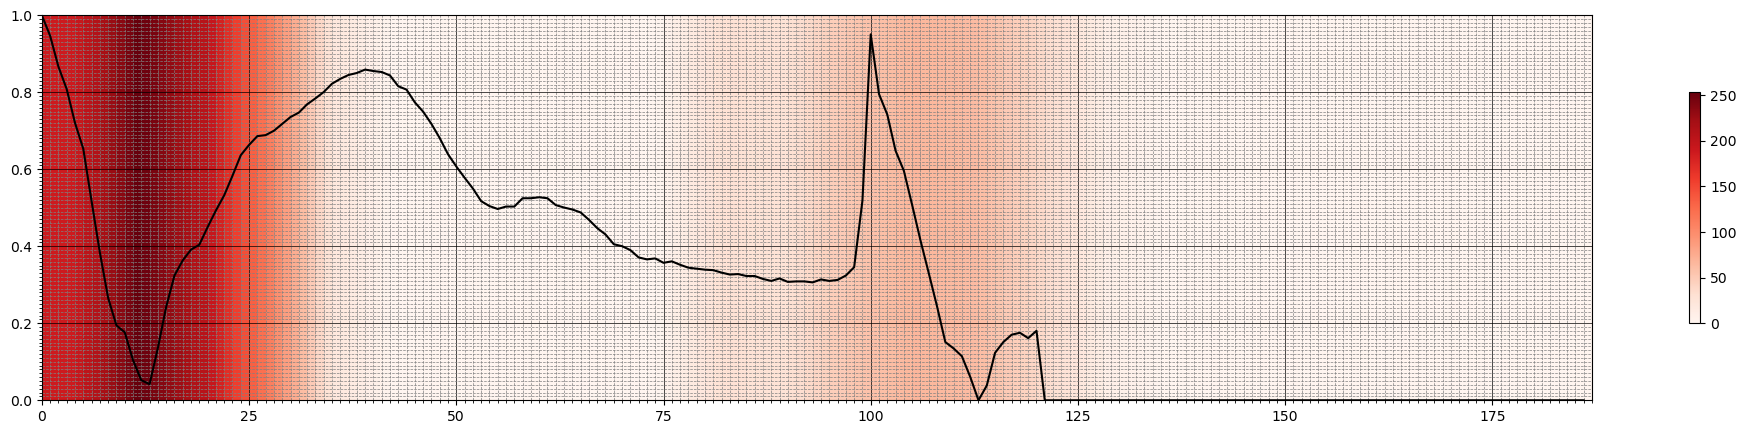

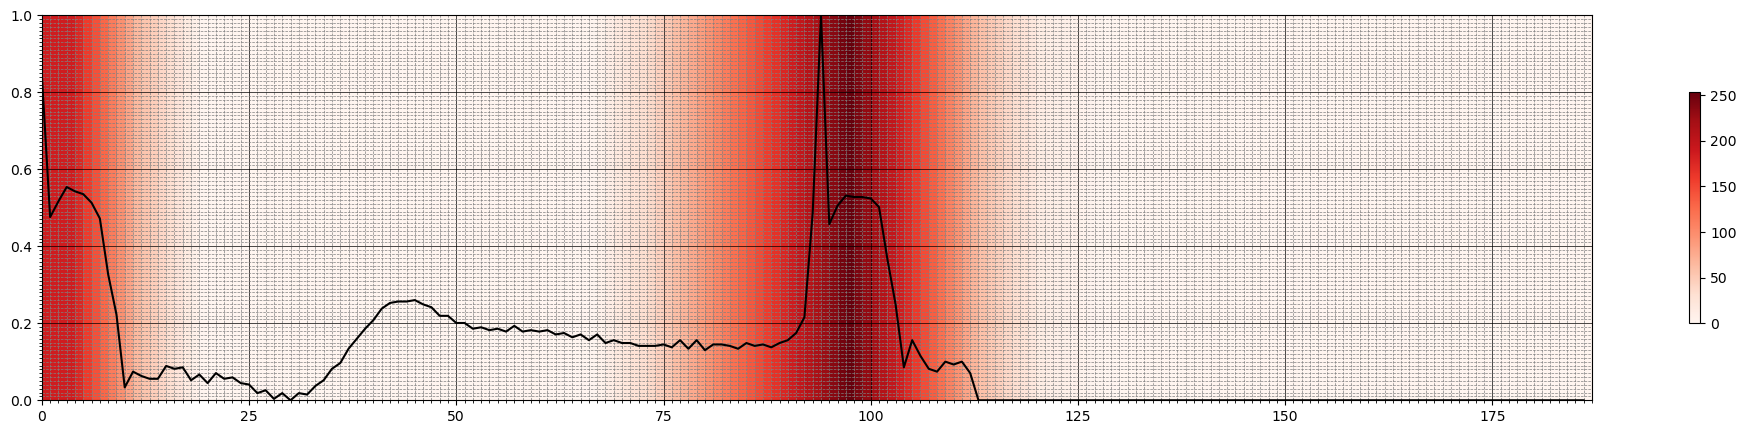

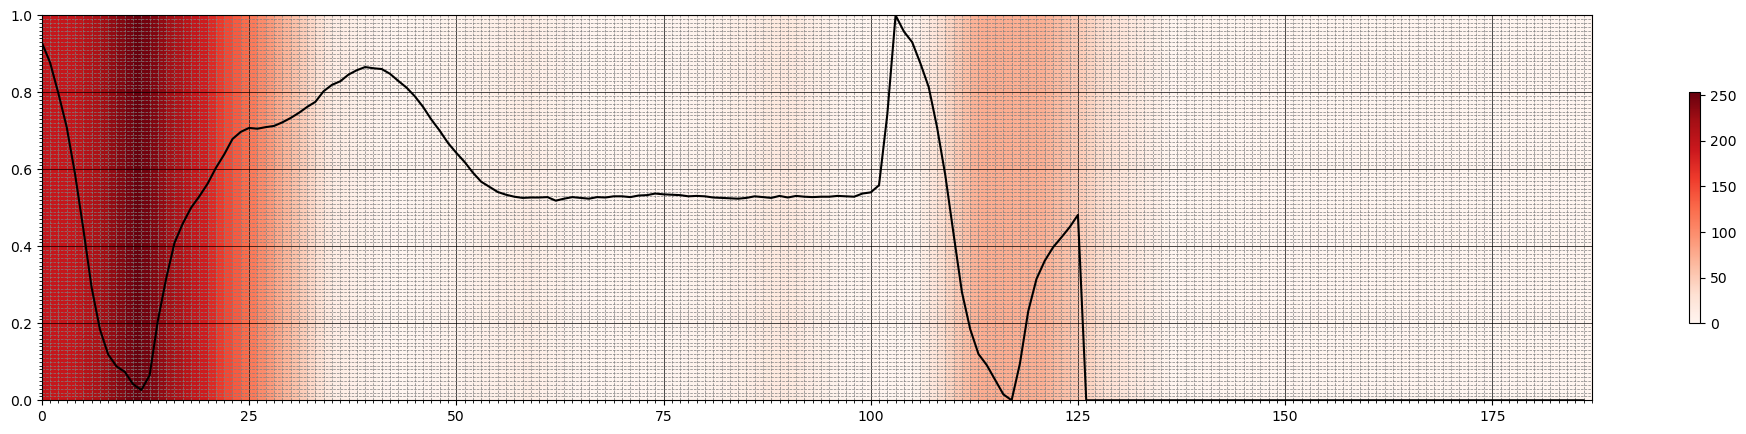

In [17]:
# Grad-CAMs that belongs to class Q
for i in range(20306,20311):
  get_prediction(i)


To say that an ECG is normal, a doctor will compare it to a reference ECG signal and check if they are similar. If the signals are not similar, there is a pathology. In the figure below, you can see what a reference ECG signal looks like. 

<img src="..//docs/source/_figures/ecg.png" alt="Image Title" width="800" height="500">

We can see that the model's prediction looks at the beginning of the signal and the peaks, mainly focusing on the beginning of some signals.

For example, Grad-CAMs belonging to class F had peaks larger than the other classes. Grad-CAMs that belong to class Q have peeks to the bottom of the figures and peeks that are not tall compared to the other ECGs. Those peeks go up again after going down.

## References

[1] Mohammad Kachuee, Shayan Fazeli, and Majid Sarrafzadeh. "ECG Heartbeat Classification: A Deep Transferable Representation." arXiv preprint arXiv:1805.00794 (2018).

[2] R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh and D. Batra, "Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization," IEEE International Conference on Computer Vision (ICCV), Venice, Italy, 2017, pp. 618-626,